<a href="https://colab.research.google.com/github/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/CV_Uebung_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SoSe 21
## Übung 1: UMBILDUNG

## Import packets

In [1]:
# Import required packets
if 'google.colab' in str(get_ipython()): #If running in colab 
    import google.colab
    IN_COLAB = True
    import IPython
    if (not IPython.__version__.startswith('5')): # Checking if plt 7.X is installed
        print('Installing IPython version 5.X to run this notebook...')
        !pip install IPython
    from IPython.display import Image
    import PIL
    if (not PIL.__version__.startswith('7')): # Checking if PIL 7.X is installed
        print('Installing pillow version 7.X to run this notebook...')
        !pip install pillow

else:
    IN_COLAB = False

# pandas and numpy
import pandas as pd
import numpy as np

# matplotlib for showing images
import matplotlib

# io for image loading and preprocessing
import skimage

# PIL package for predefined affin transformation functions
import PIL

if (not pd.__version__.startswith('1')): # Checking if pd 1.X is installed
    print('Installing pandas version 1.X to run this notebook...')
    !pip install pandas

if (not np.__version__.startswith('1')): # Checking if np 1.X is installed
    print('Installing numpy version 1.X to run this notebook...')
    !pip install numpy

if (not PIL.__version__.startswith('7')): # Checking if PIL 7.X is installed
    print('Installing pillow version 7.X to run this notebook...')
    !pip install pillow

if (not skimage.__version__.startswith('0')): # Checking if skimage 0.X is installed
    print('Installing scikit-image version 0.X to run this notebook...')
    !pip install scikit-image

if (not matplotlib.__version__.startswith('3')): # Checking if plt 3.X is installed
    print('Installing matplotlib version 3.X to run this notebook...')
    !pip install matplotlib

    # matplotlib for showing images
import matplotlib.pyplot as plt

# io for image loading and preprocessing
from skimage import io

# PIL package for predefined affin transformation functions
from PIL import Image

print('Pandas version:',pd.__version__,' Numpy version:',np.__version__, 
      ' Pillow version:',PIL.__version__,' Scikit-image version:',skimage.__version__, 
      ' Matplotlib version:',matplotlib.__version__,' Running in Google Colab?:', IN_COLAB)

Pandas version: 1.1.5  Numpy version: 1.19.5  Pillow version: 7.1.2  Scikit-image version: 0.16.2  Matplotlib version: 3.2.2  Running in Google Colab?: True


## Load and show test images

In [2]:
# mount google drive first
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%ls drive/MyDrive/CV

Mounted at /content/drive
ambassadors.jpg  gletscher.jpg


Text(0.5, 1.0, 'Abb. 2: Ambassadors')

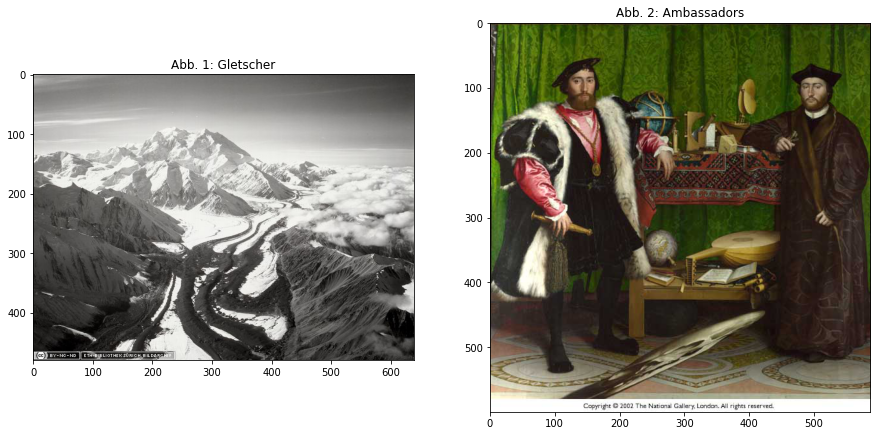

In [3]:
# Load image

#gletscher = Image("https://github.com/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/gletscher.jpg")
#ambassadors = Image("https://github.com/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/ambassadors.jpg")

gletscher = plt.imread("drive/MyDrive/CV/gletscher.jpg")
ambassadors = plt.imread("drive/MyDrive/CV/ambassadors.jpg")

gletscher_pil = Image.open("drive/MyDrive/CV/gletscher.jpg")
ambassadors_pil = Image.open("drive/MyDrive/CV/ambassadors.jpg")

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, (1))
plt.imshow(gletscher)
plt.title("Abb. 1: Gletscher")

plt.subplot(1, 2, (2))
plt.imshow(ambassadors)
plt.title("Abb. 2: Ambassadors")

## a) Function for affin transformation of test image

In [22]:
def affin_transform_image(A, image, interpolation="bilinear"):
    """
    Eine Python-Funktion, mit der sich ein Bild affin transformieren
    läßt. Übergabeparameter sind die Matrix A, der Verschiebungsvektor a0_ und das
    Eingangsbild, zurückgegeben wird das affin verzerrte Ausgangsbild. 
    Der Benutzer kann dabei zwischen Nächster-Nachbar- und bilinearer Interpolation
    wählen. 
    Alle Pixel, deren Ausgangsposition außerhalb des Eingangsbildes
    liegen, werden auf 0 gesetzt. 
    Die Funktion kann sowohl Grauwert- als auch Farbbilder verarbeiten.

    :param A: The rotation matrix a for the image transformation
    :type A: float32
    :param image: The entrance image, which should be affin tranformed
    :type image: float32
    :param interpolation: The interpolation type performed on the image (default bilinear)
    :type interpolation: String

    :return: affin_image: The affin transformed image
    :rtype: float32
    """

    # shape of image
    rows, columns, channels = image.shape
    
    # First thing that must happen is the image must be translated so that 
    # the origin (0, 0) is in the middle of the image. In the case of the 
    # rows x columns image a translation of -rows/2 in the x and -columns/2 y.
    # recenter resultant image
    A_neg = np.array([
    [1, 0, -columns/2],
    [0, 1, -rows/2],
    [0, 0, 1]])

    # Next another translation matrix needs to be applied which acts to reposition 
    # the spatial domain of the pixels essentially negating the first one that 
    # centered the origin. In this case I need a positive translation of rows in 
    # the x and y where columns comes from twice the original because it has been scaled up by two.
    # center original to 0,0
    A_pos = np.array([
    [1, 0, columns],
    [0, 1, rows],
    [0, 0, 1]])

    # generate full translation matrix
    A = A_pos @ A @ A_neg

    # convert and normalization
    image = image.astype("float32")/image.max()

    # 2x scaling requires at least a tranformation image array 2x the original image
    affin_image = np.zeros((2 * rows, 2 * columns, channels), dtype=np.float)

    # determine image pixel max values
    x_max, y_max = image.shape[0] - 1, image.shape[1] - 1

    # With the image data we to map the indices for each pixel of the input data 
    # to the transformed output indices using the transformation matrix A
    # # affine level tranformation x_ = A * image
    for i, row in enumerate(image):
        for j, col in enumerate(row):
            pixel_data = image[i, j, :]
            input_coords = np.array([i, j, 1])
            i_out, j_out, _ = A @ input_coords
            if i_out > x_max:
                #continue
                #i_out = x_max
                i_out = 0
            if  i_out < 0:
                #continue
                i_out = 0
            if j_out > y_max:
                #continue
                #j_out = y_max
                j_out = 0
            if  j_out < 0:
                #continue
                i_out = 0
            affin_image[int(i_out), int(j_out), :] = pixel_data
    
    # Plotting the image after applying the transformation clearly shows that 
    # the result is now obviously diminished as you can easily see discontinuity 
    # in the pixel intensities.
    plt.figure(figsize=(22, 16))
    plt.subplot(1, 2, (1))
    plt.imshow(affin_image)
    plt.title("Abb. 1: Affin image without interpolation")

    # inverting transformation matrix A
    A_inv = np.linalg.inv(A)

    # nearest neighbors interpolation
    def nearest_neighbors(i, j, M, A_inv):
        x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
        input_coords =  np.array([i, j, 1])
        x, y, _ = A_inv @ input_coords
        if np.floor(x) == x and np.floor(y) == y:
           x, y = int(x), int(y)
        if x > x_max:
            return 0
        if  x < 0:
            return 0
        if y > y_max:
            return 0
        if  y < 0:
            return 0
        if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
            x = int(np.floor(x))
        else:
            x = int(np.ceil(x))
        if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
            y = int(np.floor(y))
        else:
            y = int(np.ceil(y))
        return M[x, y,]

    # biliear interpolation
    def biliear(i, j, M, A_inv):
        x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
        input_coords =  np.array([i, j, 1])
        x, y, _ = A_inv @ input_coords
        if np.floor(x) == x and np.floor(y) == y:
           x, y = int(x), int(y)
        if x > x_max:
            return 0
        if  x < 0:
            return 0
        if y > y_max:
            return 0
        if  y < 0:
            return 0
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        h = x - x1
        v = y - y1
        # # bilineare Interpolation gX = A4g(P1) + A3g(P2) + A2g(P3) + A1g(P4)
        # gX = A4g(P1) + A3g(P2) + A2g(P3) + A1g(P4)
        gx = (1-h)*(1-v)*M[x1,y1,:]+(h)*(1-v)*M[x2,y1,:]+(1-h)*(v)*M[x1,y2,:]+(h)*(v)*M[x2,y2,:]
        return gx

    # affine transformation with interpolation
    # Koordinaten der Pixelmittelpunkte mit der inversen Transformation auf die ursprüngliche
    # Position im Ausgangsbild zurückgerechnet und der dortige Grauwert ausgelesen
    affin_image = np.zeros((2 * rows, 2 * columns, channels), dtype=np.float)
    for i, row in enumerate(affin_image):
        for j, col in enumerate(row):
            if interpolation=="naechster-nachbar":
                affin_image[i, j, :] = nearest_neighbors(i, j, image, A_inv)
            if interpolation=="bilinear":
                affin_image[i, j, :] = biliear(i, j, image, A_inv)

    if interpolation=="bilinear":
        affin_image = affin_image/affin_image.max()

    plt.subplot(1, 2, (2))
    plt.imshow(affin_image)
    plt.title("Abb. 2: Affin image with {} interpolation".format(interpolation))

    return affin_image

In [5]:
def pil_affin_transform(A, image, interpolation="bilinear"):
    """
    Eine Python-Funktion, mit der sich ein Bild affin transformieren
    läßt. Übergabeparameter sind die Matrix A, der Verschiebungsvektor a0_ und das
    Eingangsbild, zurückgegeben wird das affin verzerrte Ausgangsbild. 
    Der Benutzer kann dabei zwischen Nächster-Nachbar- und bilinearer Interpolation
    wählen. 
    Alle Pixel, deren Ausgangsposition außerhalb des Eingangsbildes
    liegen, werden auf 0 gesetzt. 
    Die Funktion kann sowohl Grauwert- als auch Farbbilder verarbeiten.

    :param A: The rotation matrix a for the image transformation
    :type A: float32
    :param image: The entrance image, which should be affin tranformed
    :type image: float32
    :param interpolation: The interpolation type performed on the image (default bilinear)
    :type interpolation: String

    :return: affin_image: The affin transformed image
    :rtype: float32
    """
    # image shape
    rows = image.height
    columns = image.width
    channels = len(image.getbands())

    # First thing that must happen is the image must be translated so that 
    # the origin (0, 0) is in the middle of the image. In the case of the 
    # rows x columns image a translation of -rows/2 in the x and -columns/2 y.
    # recenter resultant image
    A_neg = np.array([
    [1, 0, -columns/2],
    [0, 1, -rows/2],
    [0, 0, 1]])
    

    # Next another translation matrix needs to be applied which acts to reposition 
    # the spatial domain of the pixels essentially negating the first one that 
    # centered the origin. In this case I need a positive translation of rows in 
    # the x and y where columns comes from twice the original because it has been scaled up by two.
    # center original to 0,0
    A_pos = np.array([
    [1, 0, columns],
    [0, 1, rows],
    [0, 0, 1]])

    # generate full translation matrix
    A = A_pos @ A @ A_neg

    # inverse of the transformation matrix
    A_inv = np.linalg.inv(A)

    if interpolation=="naechster-nachbar":
        # affin transformation and nearest neighbor interpolation using PIL
        affin_image = image.transform((2 * columns, 2 *  rows), Image.AFFINE, data=A_inv.flatten()[:6], resample=Image.NEAREST)

    if interpolation=="bilinear":
        # affin transformation and bilinear interpolation using PIL
        affin_image = image.transform((2 * columns, 2 *  rows), Image.AFFINE, data=A_inv.flatten()[:6], resample=Image.BILINEAR)

    plt.figure(figsize=(10, 10))
    plt.imshow(np.asarray(affin_image))
    plt.title("Abb. 3: Affin image with {} interpolation from PIL".format(interpolation))

    return affin_image

## Define Transformations

In [19]:
# Rotation
def get_rotation(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])

# Translation
def get_translation(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

# Scale
def get_scale(sx, sy):
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

# Shear
def get_shear(sh, sv):
    return np.array([
        [ 1, sh, 0],
        [sv, 1,  0],
        [ 0, 0,  1]
    ])

## b) Affine Transformationen des Testbildes durch geeignete Wahl der Transformationsmatrix: 

> (1) Drehen Sie ein beliebiges Bild (z.B. gletscher.jpg) um 30◦

> (2) verkleinern Sie es um den Faktor 0.7

> (3) verkleinern Sie es in x-Richtung um den Faktor 0.8, vergrößern Sie es in y-Richtung um den Faktor 1.2

> (4) Dehnen Sie das Bild entlang der Diagonalen um 1.5, stauchen Sie senkrecht dazu um 0.5

> (5) Entzerren Sie das Objekt zu Füßen der Botschafter im Bild ambassadors.jpg.

> Vergleichen Sie dabei die Ergebnisse für Nächste-Nachbar- und bilineare Interpolation.









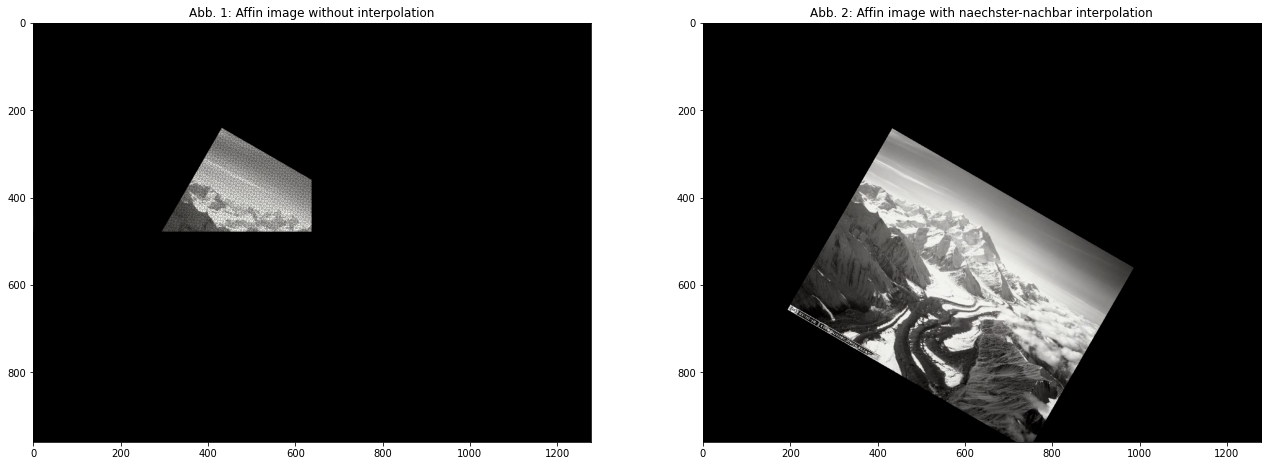

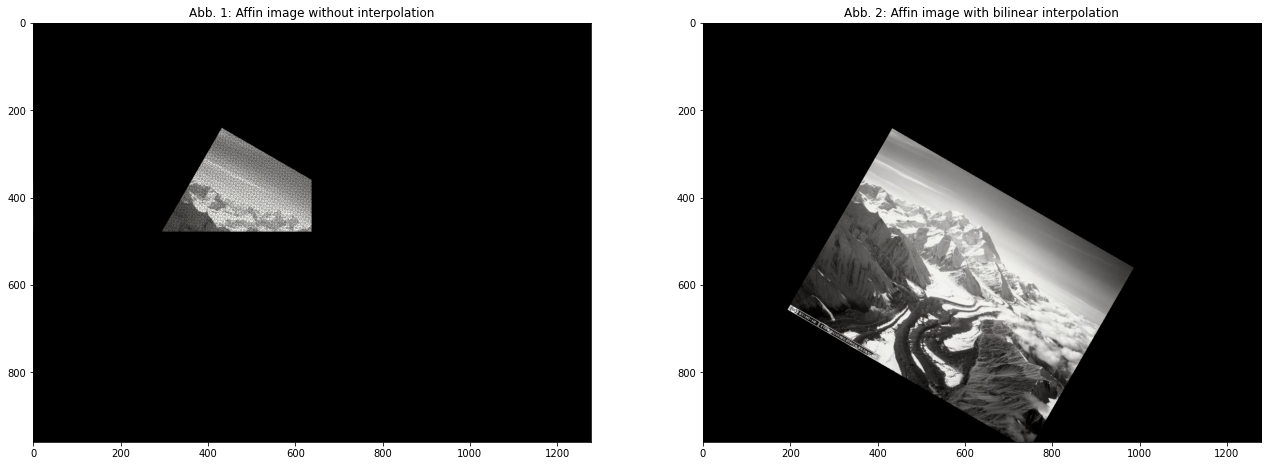

In [49]:
# (1) rotation with 30°
R = get_rotation(-30)
affin_image1 = affin_transform_image(R, gletscher, interpolation="naechster-nachbar")
affin_image2 = affin_transform_image(R, gletscher, interpolation="bilinear")

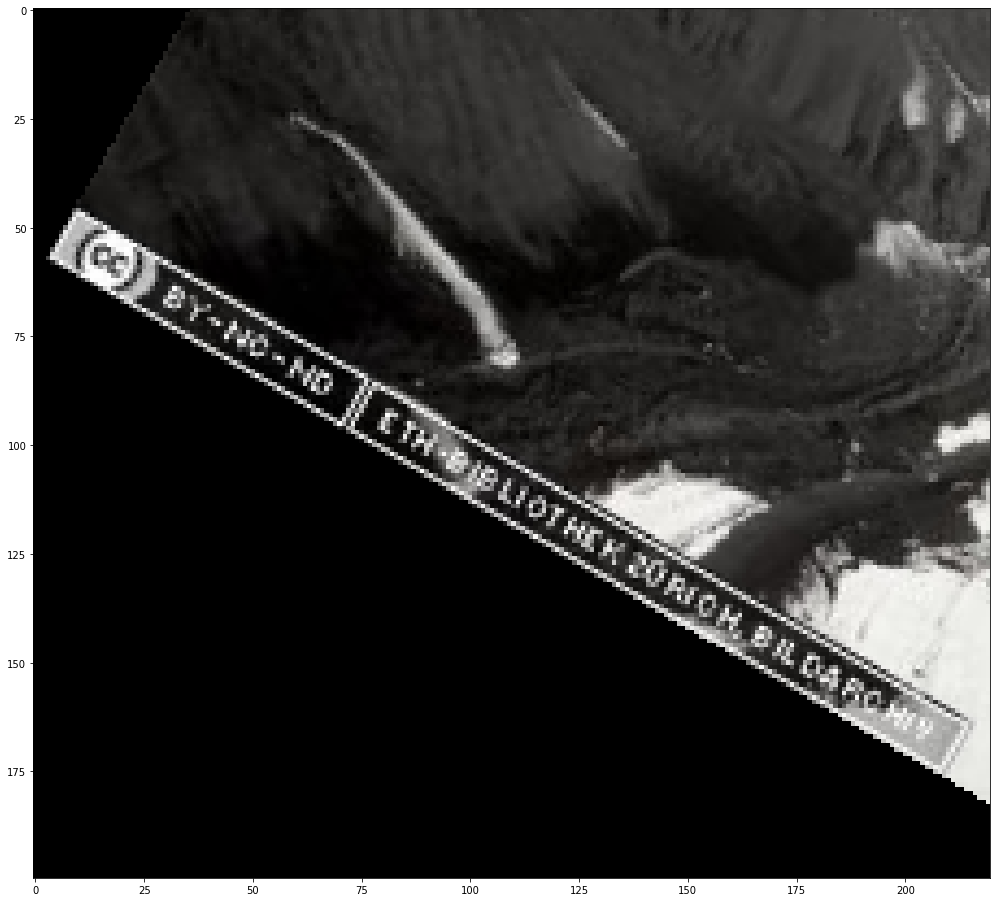

In [51]:
plt.figure(figsize=(22, 16))
plt.imshow(affin_image2[600:800, 190:410])

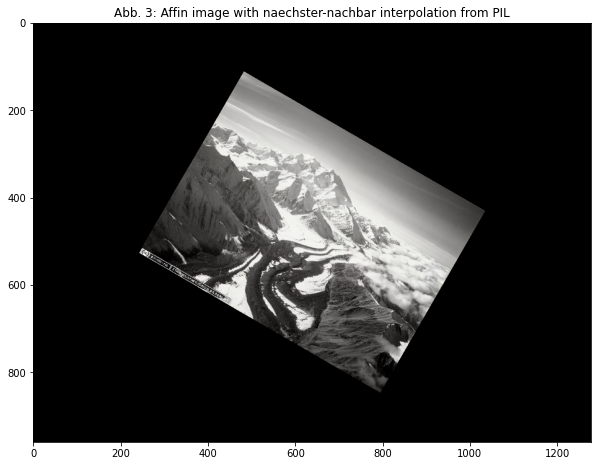

In [ ]:
# (1) rotation with 30° with PIL
R = get_rotation(30)
affin_image = pil_affin_transform(R, gletscher_pil, interpolation="naechster-nachbar")

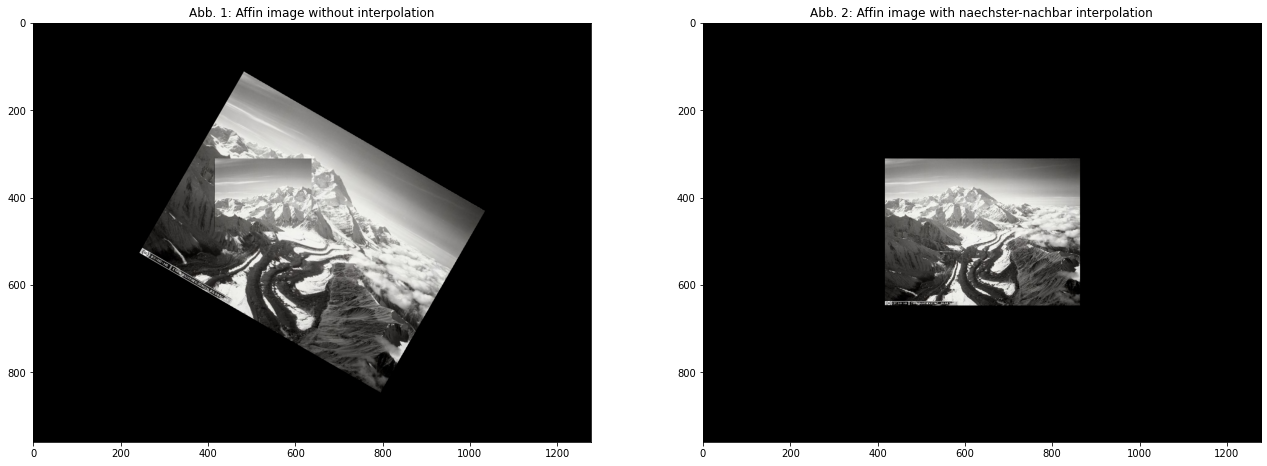

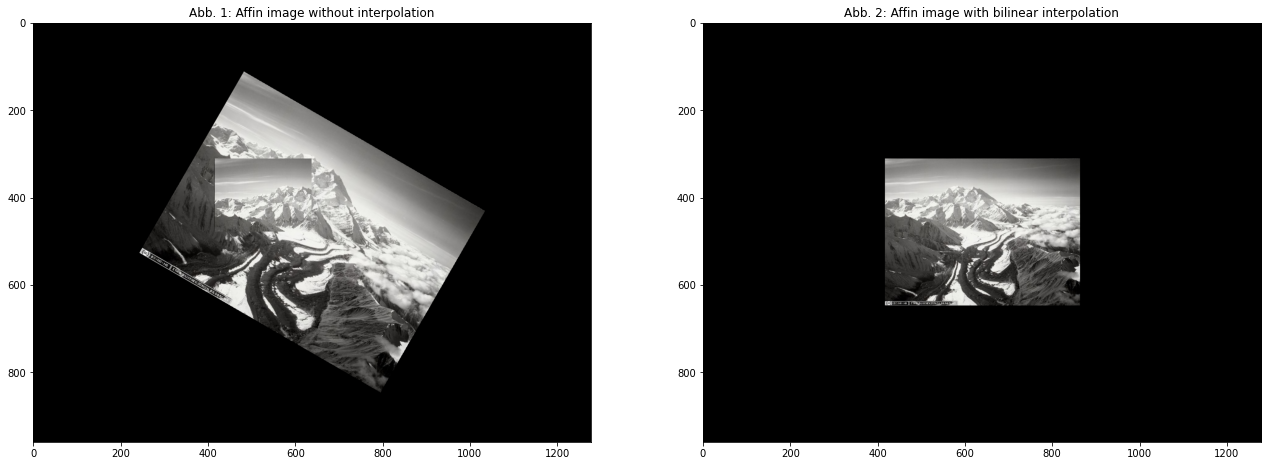

In [ ]:
# (2) scaling smaller with factor 0.7
SC = get_scale(0.7, 0.7)
affin_image = affin_transform_image(SC, gletscher, interpolation="naechster-nachbar")
affin_image = affin_transform_image(SC, gletscher, interpolation="bilinear")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


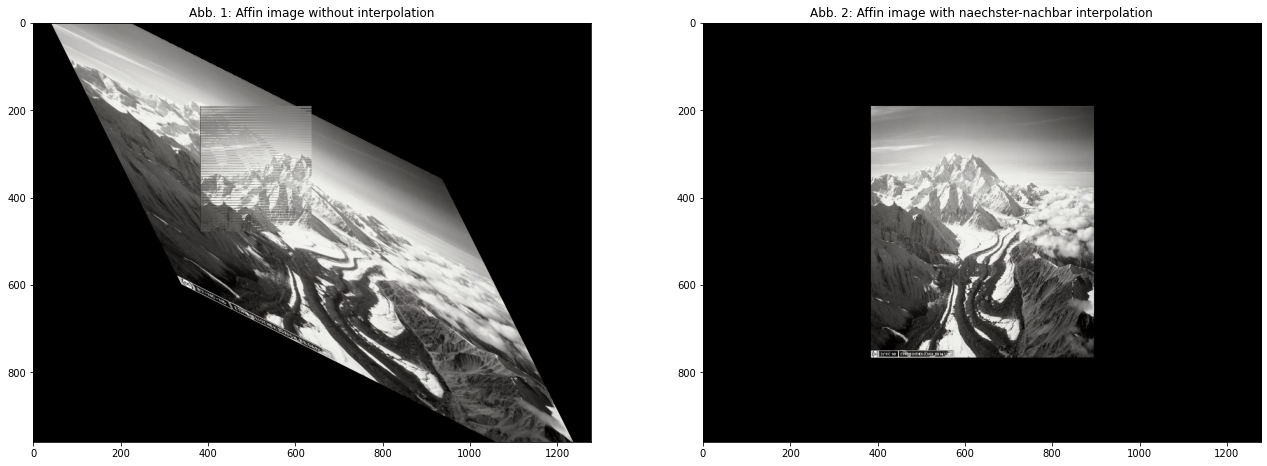

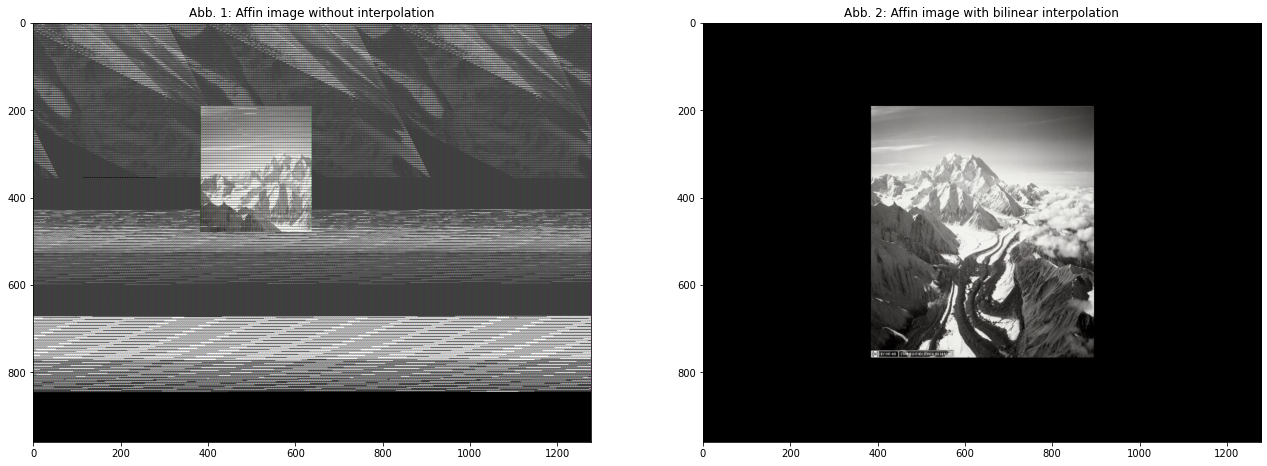

In [ ]:
# (3) scale x smaller with factor 0.8 and scale y up with factor 1.2
R = get_rotation(0)
SC = get_scale(1.2, 0.8)
A = R @ SC
affin_image = affin_transform_image(A, gletscher, interpolation="naechster-nachbar")
affin_image = affin_transform_image(A, gletscher, interpolation="bilinear")

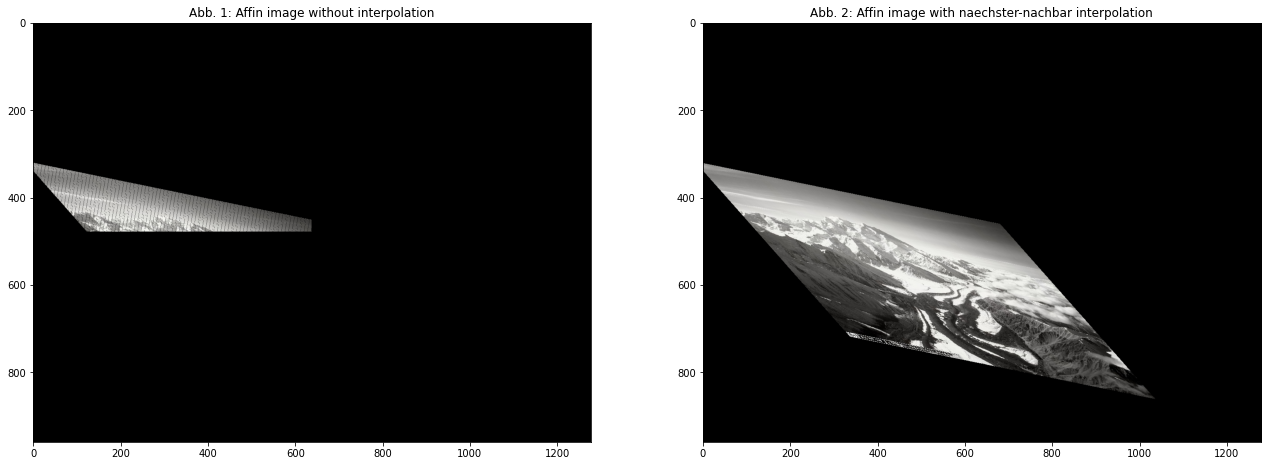

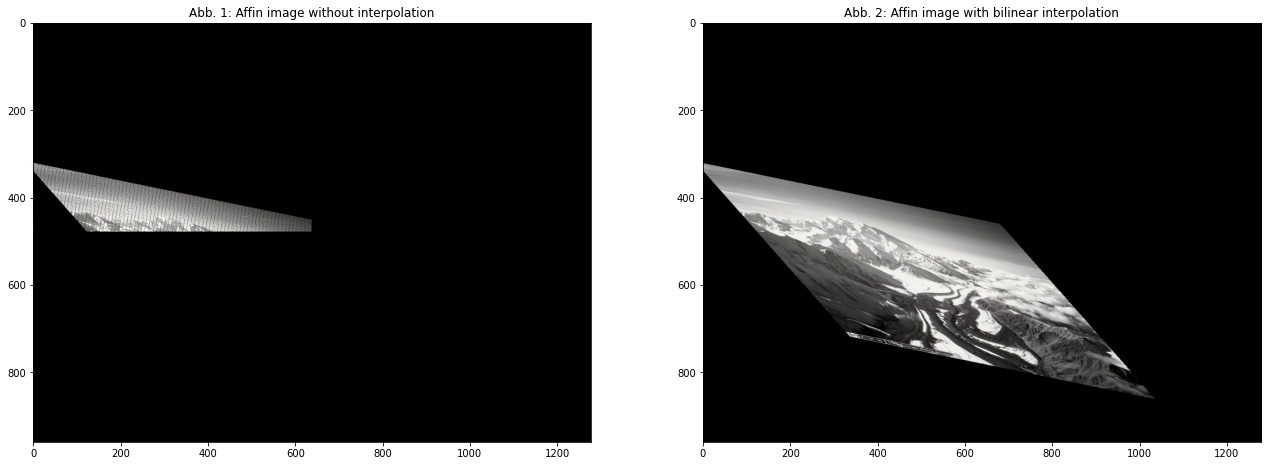

In [48]:
# (4) scale diagonal with factor 1.5, scale vertical with factor 0.5
R1 = get_rotation(-45)
R2 = get_rotation(45)
SC = get_scale(0.5, 1.5)
A = R @ SC @ R2
affin_image = affin_transform_image(A, gletscher, interpolation="naechster-nachbar")
affin_image = affin_transform_image(A, gletscher, interpolation="bilinear")

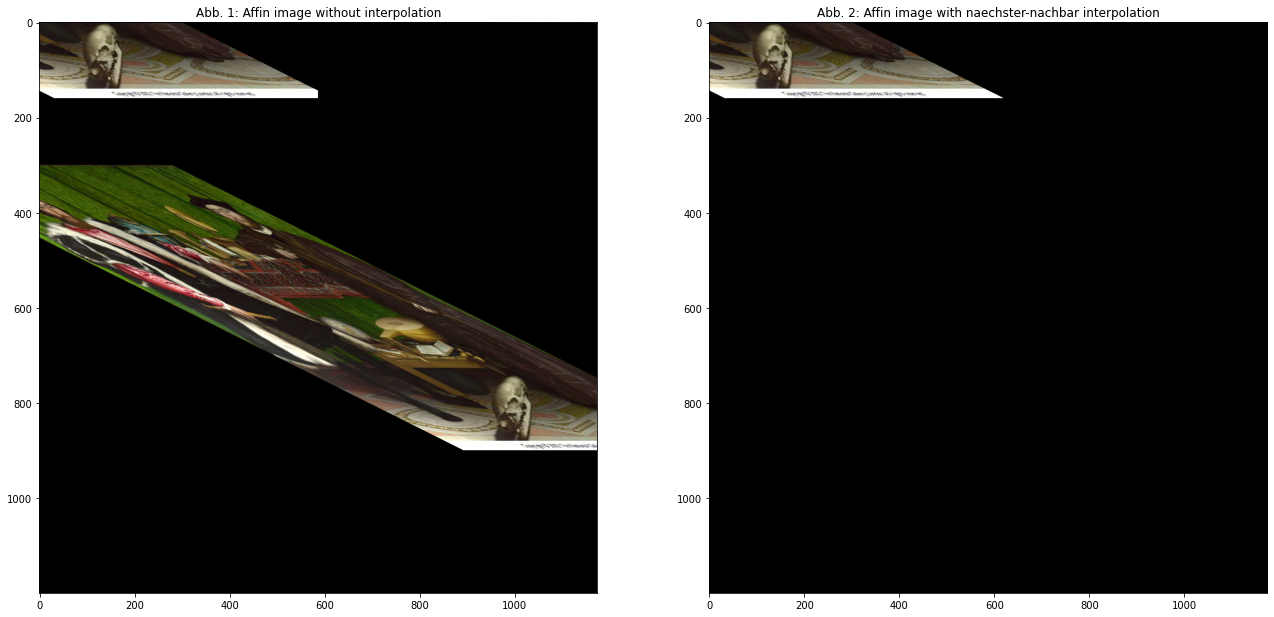

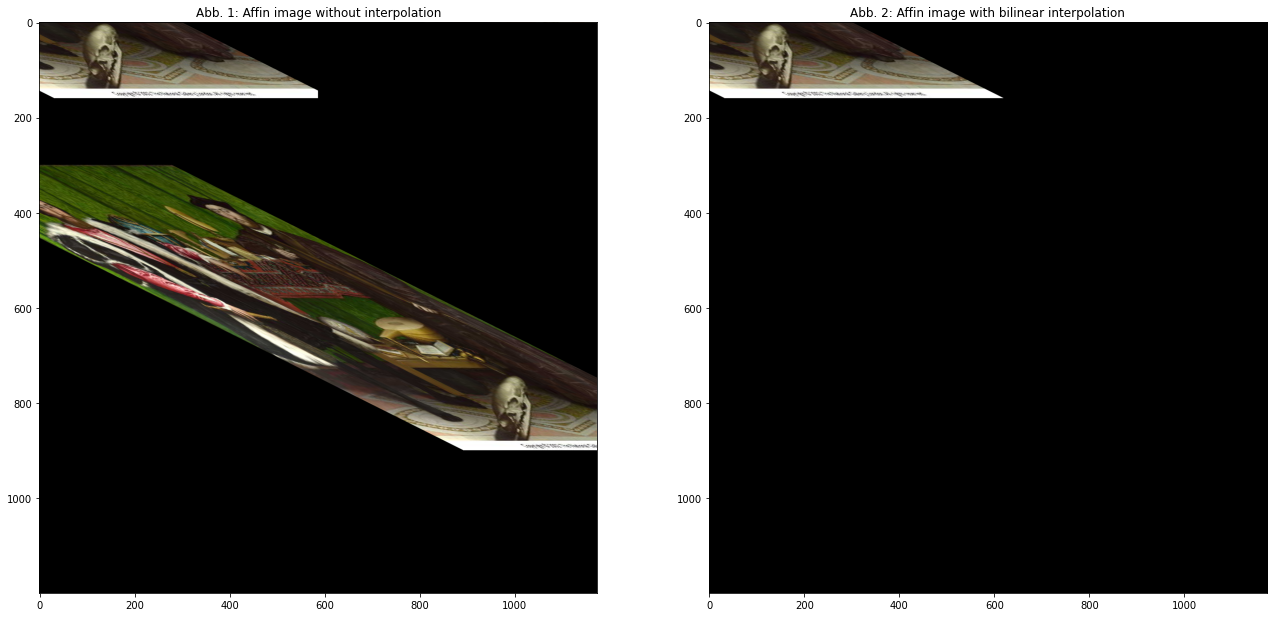

In [ ]:
# (5) equalize bottom of ambassador image with factor 2
A_scale = get_scale(1.2, 0.3)
A_rotate = get_rotation(-25)
A_pos = get_translation(-550, -400)
#A = A_scale @ A_rotate @ A_pos
T = get_translation(-740, -860)
SH = get_shear(0, 2)
A = T @ SH
affin_image = affin_transform_image(A, ambassadors, interpolation="naechster-nachbar")
affin_image = affin_transform_image(A, ambassadors, interpolation="bilinear")

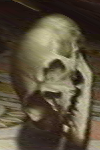

In [ ]:
# (5) equalize bottom of ambassador image with factor 2
T = get_translation(-1250, -430)
SH = get_shear(2, 0)
A = T @ SH
ambassadors_pil.transform((100, 150), Image.AFFINE, data=np.linalg.inv(A).flatten()[:6], resample=Image.NEAREST)